In [16]:
pip install torch

     |████████████████████████████████| 80.5 MB 23.2 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
from tqdm import tqdm
from glob import glob
import argparse
import torch
import torch.nn.functional as F
from skimage.io import imread, imsave
#from hausdorff import hausdorff_distance

from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,precision_recall_fscore_support

In [2]:
def mean_iou(y_true_in, y_pred_in, print_table=False):
    if True: #not np.sum(y_true_in.flatten()) == 0:
        labels = y_true_in
        y_pred = y_pred_in

        true_objects = 2
        pred_objects = 2

        intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

        # Compute areas (needed for finding the union between all objects)
        area_true = np.histogram(labels, bins = true_objects)[0]
        area_pred = np.histogram(y_pred, bins = pred_objects)[0]
        area_true = np.expand_dims(area_true, -1)
        area_pred = np.expand_dims(area_pred, 0)

        # Compute union
        union = area_true + area_pred - intersection

        # Exclude background from the analysis
        intersection = intersection[1:,1:]
        union = union[1:,1:]
        union[union == 0] = 1e-9

        # Compute the intersection over union
        iou = intersection / union

        # Precision helper function
        def precision_at(threshold, iou):
            matches = iou > threshold
            true_positives = np.sum(matches, axis=1) == 1   # Correct objects
            false_positives = np.sum(matches, axis=0) == 0  # Missed objects
            false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
            tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
            return tp, fp, fn

        # Loop over IoU thresholds
        prec = []
        if print_table:
            print("Thresh\tTP\tFP\tFN\tPrec.")
        for t in np.arange(0.5, 1.0, 0.05):
            tp, fp, fn = precision_at(t, iou)
            if (tp + fp + fn) > 0:
                p = tp / (tp + fp + fn)
            else:
                p = 0
            if print_table:
                print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
            prec.append(p)

        if print_table:
            print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
        return np.mean(prec)

    else:
        if np.sum(y_pred_in.flatten()) == 0:
            return 1
        else:
            return 0


def batch_iou(output, target):
    output = torch.sigmoid(output).data.cpu().numpy() > 0.5
    target = (target.data.cpu().numpy() > 0.5).astype('int')
    output = output[:,0,:,:]
    target = target[:,0,:,:]

    ious = []
    for i in range(output.shape[0]):
        ious.append(mean_iou(output[i], target[i]))

    return np.mean(ious)


def mean_iou(output, target):
    smooth = 1e-5

    output = torch.sigmoid(output).data.cpu().numpy()
    target = target.data.cpu().numpy()
    ious = []
    for t in np.arange(0.5, 1.0, 0.05):
        output_ = output > t
        target_ = target > t
        intersection = (output_ & target_).sum()
        union = (output_ | target_).sum()
        iou = (intersection + smooth) / (union + smooth)
        ious.append(iou)

    return np.mean(ious)


def iou_score(output, target):
    smooth = 1e-5

    if torch.is_tensor(output):
        output = torch.sigmoid(output).data.cpu().numpy()
    if torch.is_tensor(target):
        target = target.data.cpu().numpy()
    output_ = output > 0.5
    target_ = target > 0.5
    intersection = (output_ & target_).sum()
    union = (output_ | target_).sum()

    return (intersection + smooth) / (union + smooth)


def dice_coef(output, target):
    smooth = 1e-5

    if torch.is_tensor(output):
        output = torch.sigmoid(output).data.cpu().numpy()
    if torch.is_tensor(target):
        target = target.data.cpu().numpy()
    #output = torch.sigmoid(output).view(-1).data.cpu().numpy()
    #target = target.view(-1).data.cpu().numpy()

    intersection = (output * target).sum()

    return (2. * intersection + smooth) / \
        (output.sum() + target.sum() + smooth)

def ppv(output, target):
    smooth = 1e-5
    if torch.is_tensor(output):
        output = torch.sigmoid(output).data.cpu().numpy()
    if torch.is_tensor(target):
        target = target.data.cpu().numpy()
    intersection = (output * target).sum()
    return  (intersection + smooth) / \
           (output.sum() + smooth)

def sensitivity(output, target):
    smooth = 1e-5

    if torch.is_tensor(output):
        output = torch.sigmoid(output).data.cpu().numpy()
    if torch.is_tensor(target):
        target = target.data.cpu().numpy()

    intersection = (output * target).sum()

    return (intersection + smooth) / \
        (target.sum() + smooth)



In [100]:
wt_f1_score = []
tc_f1_score = []
et_f1_score = []
wt_accuracy = []
tc_accuracy = []
et_accuracy = []
wt_dices = []
tc_dices = []
et_dices = []
wt_sensitivities = []
tc_sensitivities = []
et_sensitivities = []
wt_ppvs = []
tc_ppvs = []
et_ppvs = []


wtMaskList = []
tcMaskList = []
etMaskList = []
wtPbList = []
tcPbList = []
etPbList = []

maskPath = glob("/Users/wushu/Desktop/MSc Project/Project/UNet2D/output/ShuWu_Unet_woDS/" + "GT/*.png")
pbPath = glob("/Users/wushu/Desktop/MSc Project/Project/UNet2D/output/ShuWu_Unet_woDS/" + "*.png")

for myi in tqdm(range(len(maskPath))):
    mask = imread(maskPath[myi])
    pb = imread(pbPath[myi])

    wtmaskregion = np.zeros([mask.shape[0], mask.shape[1]], dtype=np.float32)
    wtpbregion = np.zeros([mask.shape[0], mask.shape[1]], dtype=np.float32)

    tcmaskregion = np.zeros([mask.shape[0], mask.shape[1]], dtype=np.float32)
    tcpbregion = np.zeros([mask.shape[0], mask.shape[1]], dtype=np.float32)

    etmaskregion = np.zeros([mask.shape[0], mask.shape[1]], dtype=np.float32)
    etpbregion = np.zeros([mask.shape[0], mask.shape[1]], dtype=np.float32)

    for idx in range(mask.shape[0]):
        for idy in range(mask.shape[1]):
            # As long as any channel of the pixel has a value, 
            # it means that the pixel does not belong to the foreground 
            # and belongs to the WT region.
                wtmaskregion[idx, idy] = 1
            if pb[idx, idy, :].any() != 0:
                wtpbregion[idx, idy] = 1
            # As long as the first channel is 255, 
            # it is considered to be in the TC region, 
            # because the first channel in both red and yellow is 255, 
            # which distinguishes it from green.
            if mask[idx, idy, 0] == 255:
                tcmaskregion[idx, idy] = 1
            if pb[idx, idy, 0] == 255:
                tcpbregion[idx, idy] = 1
            # As long as the second channel is 128, 
            # it is considered to be the ET region.
            if mask[idx, idy, 1] == 128:
                etmaskregion[idx, idy] = 1
            if pb[idx, idy, 1] == 128:
                etpbregion[idx, idy] = 1
                
    # Calculate WT --whole tumor (WT)
    accuracy_n = accuracy_score(wtpbregion,wtmaskregion)
    wt_accuracy.append(accuracy_n)
    f1_score_n = f1_score(wtpbregion,wtmaskregion,average=None)
    wt_f1_score.append(f1_score_n)
    dice = dice_coef(wtpbregion,wtmaskregion)
    wt_dices.append(dice)
    ppv_n = ppv(wtpbregion, wtmaskregion)
    wt_ppvs.append(ppv_n)
    sensitivity_n = sensitivity(wtpbregion, wtmaskregion)
    wt_sensitivities.append(sensitivity_n)
    
    # Calculate TC --tumor core (TC)
    accuracy_n = accuracy_score(tcpbregion,tcmaskregion)
    tc_accuracy.append(accuracy_n)
    f1_score_n = f1_score(tcpbregion,tcmaskregion,average=None)
    tc_f1_score.append(f1_score_n)
    dice = dice_coef(tcpbregion, tcmaskregion)
    tc_dices.append(dice)
    ppv_n = ppv(tcpbregion, tcmaskregion)
    tc_ppvs.append(ppv_n)
    sensitivity_n = sensitivity(tcpbregion, tcmaskregion)
    tc_sensitivities.append(sensitivity_n)
    
    # Calculate ET --enhancing tumor (ET)
    accuracy_n = accuracy_score(etpbregion,etmaskregion)
    et_accuracy.append(accuracy_n)
    f1_score_n = f1_score(etpbregion,etmaskregion,average=None)
    et_f1_score.append(f1_score_n)
    dice = dice_coef(etpbregion, etmaskregion)
    et_dices.append(dice)
    ppv_n = ppv(etpbregion, etmaskregion)
    et_ppvs.append(ppv_n)
    sensitivity_n = sensitivity(etpbregion, etmaskregion)
    et_sensitivities.append(sensitivity_n)

print('WT Dice: %.4f' % np.mean(wt_dices))
print('TC Dice: %.4f' % np.mean(tc_dices))
print('ET Dice: %.4f' % np.mean(et_dices))
print("=============")
print('WT PPV: %.4f' % np.mean(wt_ppvs))
print('TC PPV: %.4f' % np.mean(tc_ppvs))
print('ET PPV: %.4f' % np.mean(et_ppvs))
print("=============")
print('WT sensitivity: %.4f' % np.mean(wt_sensitivities))
print('TC sensitivity: %.4f' % np.mean(tc_sensitivities))
print('ET sensitivity: %.4f' % np.mean(et_sensitivities))
print("=============")
print('WT Accuracy: %.4f' % np.mean(wt_accuracy))
print('TC Accuracy: %.4f' % np.mean(tc_accuracy))
print('ET Accuracy: %.4f' % np.mean(et_accuracy))
print("=============")
print('WT f1 score: %.4f' % np.mean(wt_f1_score))
print('TC f1 score: %.4f' % np.mean(tc_f1_score))
print('ET f1 score: %.4f' % np.mean(et_f1_score))
print("=============")






  0%|          | 0/3219 [00:00<?, ?it/s]




  0%|          | 1/3219 [00:00<21:03,  2.55it/s]




  0%|          | 2/3219 [00:00<20:13,  2.65it/s]




  0%|          | 3/3219 [00:01<19:27,  2.76it/s]




  0%|          | 4/3219 [00:01<18:48,  2.85it/s]




  0%|          | 5/3219 [00:01<18:19,  2.92it/s]




  0%|          | 6/3219 [00:02<18:17,  2.93it/s]




  0%|          | 7/3219 [00:02<18:02,  2.97it/s]




  0%|          | 8/3219 [00:02<17:46,  3.01it/s]




  0%|          | 9/3219 [00:03<17:37,  3.04it/s]




  0%|          | 10/3219 [00:03<17:41,  3.02it/s]




  0%|          | 11/3219 [00:03<17:35,  3.04it/s]




  0%|          | 12/3219 [00:04<17:43,  3.02it/s]




  0%|          | 13/3219 [00:04<17:36,  3.04it/s]




  0%|          | 14/3219 [00:04<17:48,  3.00it/s]




  0%|          | 15/3219 [00:05<18:08,  2.94it/s]




  0%|          | 16/3219 [00:05<18:00,  2.96it/s]




  1%|          | 17/3219 [00:05<18:01,  2.96it/s]




  1%|          | 18/3219 [00:06<18:06,  2

  7%|▋         | 235/3219 [01:18<16:29,  3.02it/s]




  7%|▋         | 236/3219 [01:19<16:35,  3.00it/s]




  7%|▋         | 237/3219 [01:19<16:27,  3.02it/s]




  7%|▋         | 238/3219 [01:19<16:27,  3.02it/s]




  7%|▋         | 239/3219 [01:20<16:21,  3.04it/s]




  7%|▋         | 240/3219 [01:20<16:23,  3.03it/s]




  7%|▋         | 241/3219 [01:20<16:23,  3.03it/s]




  8%|▊         | 242/3219 [01:21<16:25,  3.02it/s]




  8%|▊         | 243/3219 [01:21<16:20,  3.04it/s]




  8%|▊         | 244/3219 [01:21<16:17,  3.04it/s]




  8%|▊         | 245/3219 [01:22<16:19,  3.04it/s]




  8%|▊         | 246/3219 [01:22<16:19,  3.03it/s]




  8%|▊         | 247/3219 [01:22<16:22,  3.02it/s]




  8%|▊         | 248/3219 [01:23<16:27,  3.01it/s]




  8%|▊         | 249/3219 [01:23<16:27,  3.01it/s]




  8%|▊         | 250/3219 [01:23<17:08,  2.89it/s]




  8%|▊         | 251/3219 [01:24<16:59,  2.91it/s]




  8%|▊         | 252/3219 [01:24<16:50,  2.94it/s]




  8%|▊    

 15%|█▍        | 469/3219 [02:37<15:25,  2.97it/s]




 15%|█▍        | 470/3219 [02:37<15:33,  2.95it/s]




 15%|█▍        | 471/3219 [02:37<15:36,  2.93it/s]




 15%|█▍        | 472/3219 [02:38<15:38,  2.93it/s]




 15%|█▍        | 473/3219 [02:38<15:35,  2.93it/s]




 15%|█▍        | 474/3219 [02:38<15:25,  2.96it/s]




 15%|█▍        | 475/3219 [02:39<15:17,  2.99it/s]




 15%|█▍        | 476/3219 [02:39<15:24,  2.97it/s]




 15%|█▍        | 477/3219 [02:39<15:36,  2.93it/s]




 15%|█▍        | 478/3219 [02:40<15:33,  2.94it/s]




 15%|█▍        | 479/3219 [02:40<15:39,  2.92it/s]




 15%|█▍        | 480/3219 [02:40<15:38,  2.92it/s]




 15%|█▍        | 481/3219 [02:41<15:30,  2.94it/s]




 15%|█▍        | 482/3219 [02:41<15:23,  2.96it/s]




 15%|█▌        | 483/3219 [02:41<15:31,  2.94it/s]




 15%|█▌        | 484/3219 [02:42<15:21,  2.97it/s]




 15%|█▌        | 485/3219 [02:42<15:16,  2.98it/s]




 15%|█▌        | 486/3219 [02:42<15:10,  3.00it/s]




 15%|█▌   

 22%|██▏       | 703/3219 [03:53<13:32,  3.10it/s]




 22%|██▏       | 704/3219 [03:54<13:29,  3.11it/s]




 22%|██▏       | 705/3219 [03:54<13:29,  3.11it/s]




 22%|██▏       | 706/3219 [03:54<13:28,  3.11it/s]




 22%|██▏       | 707/3219 [03:54<13:27,  3.11it/s]




 22%|██▏       | 708/3219 [03:55<13:29,  3.10it/s]




 22%|██▏       | 709/3219 [03:55<13:28,  3.10it/s]




 22%|██▏       | 710/3219 [03:55<13:27,  3.11it/s]




 22%|██▏       | 711/3219 [03:56<13:29,  3.10it/s]




 22%|██▏       | 712/3219 [03:56<13:28,  3.10it/s]




 22%|██▏       | 713/3219 [03:56<13:27,  3.10it/s]




 22%|██▏       | 714/3219 [03:57<13:24,  3.11it/s]




 22%|██▏       | 715/3219 [03:57<13:29,  3.09it/s]




 22%|██▏       | 716/3219 [03:57<13:30,  3.09it/s]




 22%|██▏       | 717/3219 [03:58<13:28,  3.09it/s]




 22%|██▏       | 718/3219 [03:58<13:23,  3.11it/s]




 22%|██▏       | 719/3219 [03:58<13:25,  3.10it/s]




 22%|██▏       | 720/3219 [03:59<13:21,  3.12it/s]




 22%|██▏  

 29%|██▉       | 937/3219 [05:09<12:16,  3.10it/s]




 29%|██▉       | 938/3219 [05:09<12:13,  3.11it/s]




 29%|██▉       | 939/3219 [05:09<12:12,  3.11it/s]




 29%|██▉       | 940/3219 [05:10<12:13,  3.11it/s]




 29%|██▉       | 941/3219 [05:10<12:12,  3.11it/s]




 29%|██▉       | 942/3219 [05:10<12:10,  3.12it/s]




 29%|██▉       | 943/3219 [05:11<12:12,  3.11it/s]




 29%|██▉       | 944/3219 [05:11<12:18,  3.08it/s]




 29%|██▉       | 945/3219 [05:11<12:17,  3.08it/s]




 29%|██▉       | 946/3219 [05:12<12:14,  3.09it/s]




 29%|██▉       | 947/3219 [05:12<12:12,  3.10it/s]




 29%|██▉       | 948/3219 [05:12<12:10,  3.11it/s]




 29%|██▉       | 949/3219 [05:13<12:08,  3.12it/s]




 30%|██▉       | 950/3219 [05:13<12:07,  3.12it/s]




 30%|██▉       | 951/3219 [05:13<12:05,  3.13it/s]




 30%|██▉       | 952/3219 [05:14<12:06,  3.12it/s]




 30%|██▉       | 953/3219 [05:14<12:04,  3.13it/s]




 30%|██▉       | 954/3219 [05:14<12:05,  3.12it/s]




 30%|██▉  

 36%|███▋      | 1168/3219 [06:23<11:04,  3.09it/s]




 36%|███▋      | 1169/3219 [06:24<11:08,  3.07it/s]




 36%|███▋      | 1170/3219 [06:24<11:03,  3.09it/s]




 36%|███▋      | 1171/3219 [06:24<11:06,  3.07it/s]




 36%|███▋      | 1172/3219 [06:25<11:04,  3.08it/s]




 36%|███▋      | 1173/3219 [06:25<10:59,  3.10it/s]




 36%|███▋      | 1174/3219 [06:25<11:00,  3.10it/s]




 37%|███▋      | 1175/3219 [06:26<11:00,  3.10it/s]




 37%|███▋      | 1176/3219 [06:26<11:00,  3.09it/s]




 37%|███▋      | 1177/3219 [06:26<10:58,  3.10it/s]




 37%|███▋      | 1178/3219 [06:27<11:03,  3.07it/s]




 37%|███▋      | 1179/3219 [06:27<11:03,  3.07it/s]




 37%|███▋      | 1180/3219 [06:27<11:01,  3.08it/s]




 37%|███▋      | 1181/3219 [06:28<11:00,  3.09it/s]




 37%|███▋      | 1182/3219 [06:28<11:00,  3.08it/s]




 37%|███▋      | 1183/3219 [06:28<10:59,  3.09it/s]




 37%|███▋      | 1184/3219 [06:29<10:57,  3.09it/s]




 37%|███▋      | 1185/3219 [06:29<10:55,  3.10it

 43%|████▎     | 1398/3219 [07:38<09:46,  3.10it/s]




 43%|████▎     | 1399/3219 [07:38<09:44,  3.12it/s]




 43%|████▎     | 1400/3219 [07:38<09:47,  3.10it/s]




 44%|████▎     | 1401/3219 [07:39<09:48,  3.09it/s]




 44%|████▎     | 1402/3219 [07:39<09:46,  3.10it/s]




 44%|████▎     | 1403/3219 [07:39<09:42,  3.12it/s]




 44%|████▎     | 1404/3219 [07:40<09:48,  3.08it/s]




 44%|████▎     | 1405/3219 [07:40<09:49,  3.08it/s]




 44%|████▎     | 1406/3219 [07:40<09:48,  3.08it/s]




 44%|████▎     | 1407/3219 [07:41<09:49,  3.08it/s]




 44%|████▎     | 1408/3219 [07:41<09:47,  3.08it/s]




 44%|████▍     | 1409/3219 [07:41<09:45,  3.09it/s]




 44%|████▍     | 1410/3219 [07:42<09:50,  3.06it/s]




 44%|████▍     | 1411/3219 [07:42<09:48,  3.07it/s]




 44%|████▍     | 1412/3219 [07:42<09:43,  3.10it/s]




 44%|████▍     | 1413/3219 [07:43<09:44,  3.09it/s]




 44%|████▍     | 1414/3219 [07:43<09:43,  3.09it/s]




 44%|████▍     | 1415/3219 [07:43<09:41,  3.10it

 51%|█████     | 1628/3219 [08:52<08:32,  3.10it/s]




 51%|█████     | 1629/3219 [08:52<08:30,  3.12it/s]




 51%|█████     | 1630/3219 [08:53<08:35,  3.08it/s]




 51%|█████     | 1631/3219 [08:53<08:32,  3.10it/s]




 51%|█████     | 1632/3219 [08:53<08:30,  3.11it/s]




 51%|█████     | 1633/3219 [08:54<08:31,  3.10it/s]




 51%|█████     | 1634/3219 [08:54<08:29,  3.11it/s]




 51%|█████     | 1635/3219 [08:54<08:31,  3.10it/s]




 51%|█████     | 1636/3219 [08:54<08:31,  3.10it/s]




 51%|█████     | 1637/3219 [08:55<08:32,  3.09it/s]




 51%|█████     | 1638/3219 [08:55<08:29,  3.10it/s]




 51%|█████     | 1639/3219 [08:55<08:29,  3.10it/s]




 51%|█████     | 1640/3219 [08:56<08:26,  3.12it/s]




 51%|█████     | 1641/3219 [08:56<08:26,  3.11it/s]




 51%|█████     | 1642/3219 [08:56<08:44,  3.01it/s]




 51%|█████     | 1643/3219 [08:57<08:44,  3.00it/s]




 51%|█████     | 1644/3219 [08:57<08:45,  3.00it/s]




 51%|█████     | 1645/3219 [08:57<08:50,  2.97it

 58%|█████▊    | 1858/3219 [10:07<07:17,  3.11it/s]




 58%|█████▊    | 1859/3219 [10:07<07:16,  3.11it/s]




 58%|█████▊    | 1860/3219 [10:07<07:16,  3.11it/s]




 58%|█████▊    | 1861/3219 [10:08<07:14,  3.12it/s]




 58%|█████▊    | 1862/3219 [10:08<07:14,  3.12it/s]




 58%|█████▊    | 1863/3219 [10:08<07:15,  3.12it/s]




 58%|█████▊    | 1864/3219 [10:09<07:16,  3.11it/s]




 58%|█████▊    | 1865/3219 [10:09<07:16,  3.11it/s]




 58%|█████▊    | 1866/3219 [10:09<07:15,  3.11it/s]




 58%|█████▊    | 1867/3219 [10:10<07:15,  3.10it/s]




 58%|█████▊    | 1868/3219 [10:10<07:14,  3.11it/s]




 58%|█████▊    | 1869/3219 [10:10<07:14,  3.11it/s]




 58%|█████▊    | 1870/3219 [10:11<07:17,  3.09it/s]




 58%|█████▊    | 1871/3219 [10:11<07:16,  3.09it/s]




 58%|█████▊    | 1872/3219 [10:11<07:13,  3.10it/s]




 58%|█████▊    | 1873/3219 [10:12<07:13,  3.10it/s]




 58%|█████▊    | 1874/3219 [10:12<07:13,  3.10it/s]




 58%|█████▊    | 1875/3219 [10:12<07:13,  3.10it

 65%|██████▍   | 2088/3219 [11:21<06:10,  3.05it/s]




 65%|██████▍   | 2089/3219 [11:21<06:09,  3.06it/s]




 65%|██████▍   | 2090/3219 [11:22<06:07,  3.07it/s]




 65%|██████▍   | 2091/3219 [11:22<06:08,  3.06it/s]




 65%|██████▍   | 2092/3219 [11:22<06:08,  3.06it/s]




 65%|██████▌   | 2093/3219 [11:23<06:06,  3.08it/s]




 65%|██████▌   | 2094/3219 [11:23<06:05,  3.07it/s]




 65%|██████▌   | 2095/3219 [11:23<06:06,  3.07it/s]




 65%|██████▌   | 2096/3219 [11:24<06:04,  3.08it/s]




 65%|██████▌   | 2097/3219 [11:24<06:02,  3.09it/s]




 65%|██████▌   | 2098/3219 [11:24<06:02,  3.09it/s]




 65%|██████▌   | 2099/3219 [11:25<06:02,  3.09it/s]




 65%|██████▌   | 2100/3219 [11:25<06:02,  3.09it/s]




 65%|██████▌   | 2101/3219 [11:25<06:01,  3.09it/s]




 65%|██████▌   | 2102/3219 [11:26<06:01,  3.09it/s]




 65%|██████▌   | 2103/3219 [11:26<06:00,  3.09it/s]




 65%|██████▌   | 2104/3219 [11:26<06:01,  3.09it/s]




 65%|██████▌   | 2105/3219 [11:27<06:01,  3.08it

 72%|███████▏  | 2318/3219 [12:36<04:53,  3.07it/s]




 72%|███████▏  | 2319/3219 [12:36<04:53,  3.07it/s]




 72%|███████▏  | 2320/3219 [12:36<04:53,  3.06it/s]




 72%|███████▏  | 2321/3219 [12:37<04:52,  3.07it/s]




 72%|███████▏  | 2322/3219 [12:37<04:51,  3.08it/s]




 72%|███████▏  | 2323/3219 [12:37<04:49,  3.09it/s]




 72%|███████▏  | 2324/3219 [12:38<04:49,  3.09it/s]




 72%|███████▏  | 2325/3219 [12:38<04:48,  3.10it/s]




 72%|███████▏  | 2326/3219 [12:38<04:47,  3.10it/s]




 72%|███████▏  | 2327/3219 [12:39<04:47,  3.10it/s]




 72%|███████▏  | 2328/3219 [12:39<04:46,  3.11it/s]




 72%|███████▏  | 2329/3219 [12:39<04:47,  3.10it/s]




 72%|███████▏  | 2330/3219 [12:40<04:45,  3.11it/s]




 72%|███████▏  | 2331/3219 [12:40<04:45,  3.11it/s]




 72%|███████▏  | 2332/3219 [12:40<04:44,  3.12it/s]




 72%|███████▏  | 2333/3219 [12:41<04:46,  3.09it/s]




 73%|███████▎  | 2334/3219 [12:41<04:47,  3.08it/s]




 73%|███████▎  | 2335/3219 [12:41<04:46,  3.09it

 79%|███████▉  | 2548/3219 [13:50<03:35,  3.11it/s]




 79%|███████▉  | 2549/3219 [13:50<03:35,  3.11it/s]




 79%|███████▉  | 2550/3219 [13:51<03:36,  3.09it/s]




 79%|███████▉  | 2551/3219 [13:51<03:35,  3.11it/s]




 79%|███████▉  | 2552/3219 [13:51<03:35,  3.10it/s]




 79%|███████▉  | 2553/3219 [13:52<03:35,  3.09it/s]




 79%|███████▉  | 2554/3219 [13:52<03:35,  3.08it/s]




 79%|███████▉  | 2555/3219 [13:52<03:34,  3.09it/s]




 79%|███████▉  | 2556/3219 [13:53<03:34,  3.09it/s]




 79%|███████▉  | 2557/3219 [13:53<03:33,  3.10it/s]




 79%|███████▉  | 2558/3219 [13:53<03:33,  3.10it/s]




 79%|███████▉  | 2559/3219 [13:54<03:32,  3.11it/s]




 80%|███████▉  | 2560/3219 [13:54<03:32,  3.10it/s]




 80%|███████▉  | 2561/3219 [13:54<03:32,  3.10it/s]




 80%|███████▉  | 2562/3219 [13:55<03:32,  3.10it/s]




 80%|███████▉  | 2563/3219 [13:55<03:31,  3.10it/s]




 80%|███████▉  | 2564/3219 [13:55<03:30,  3.11it/s]




 80%|███████▉  | 2565/3219 [13:56<03:30,  3.10it

 86%|████████▋ | 2778/3219 [15:05<02:23,  3.07it/s]




 86%|████████▋ | 2779/3219 [15:05<02:22,  3.09it/s]




 86%|████████▋ | 2780/3219 [15:05<02:22,  3.08it/s]




 86%|████████▋ | 2781/3219 [15:06<02:21,  3.10it/s]




 86%|████████▋ | 2782/3219 [15:06<02:21,  3.10it/s]




 86%|████████▋ | 2783/3219 [15:06<02:20,  3.11it/s]




 86%|████████▋ | 2784/3219 [15:07<02:19,  3.11it/s]




 87%|████████▋ | 2785/3219 [15:07<02:19,  3.10it/s]




 87%|████████▋ | 2786/3219 [15:07<02:19,  3.09it/s]




 87%|████████▋ | 2787/3219 [15:08<02:19,  3.11it/s]




 87%|████████▋ | 2788/3219 [15:08<02:18,  3.11it/s]




 87%|████████▋ | 2789/3219 [15:08<02:18,  3.10it/s]




 87%|████████▋ | 2790/3219 [15:09<02:18,  3.10it/s]




 87%|████████▋ | 2791/3219 [15:09<02:18,  3.09it/s]




 87%|████████▋ | 2792/3219 [15:09<02:17,  3.10it/s]




 87%|████████▋ | 2793/3219 [15:10<02:17,  3.10it/s]




 87%|████████▋ | 2794/3219 [15:10<02:16,  3.11it/s]




 87%|████████▋ | 2795/3219 [15:10<02:16,  3.10it

 93%|█████████▎| 3008/3219 [16:19<01:08,  3.09it/s]




 93%|█████████▎| 3009/3219 [16:20<01:08,  3.07it/s]




 94%|█████████▎| 3010/3219 [16:20<01:08,  3.05it/s]




 94%|█████████▎| 3011/3219 [16:20<01:07,  3.07it/s]




 94%|█████████▎| 3012/3219 [16:21<01:07,  3.07it/s]




 94%|█████████▎| 3013/3219 [16:21<01:07,  3.07it/s]




 94%|█████████▎| 3014/3219 [16:21<01:06,  3.07it/s]




 94%|█████████▎| 3015/3219 [16:21<01:06,  3.06it/s]




 94%|█████████▎| 3016/3219 [16:22<01:06,  3.06it/s]




 94%|█████████▎| 3017/3219 [16:22<01:05,  3.07it/s]




 94%|█████████▍| 3018/3219 [16:22<01:05,  3.07it/s]




 94%|█████████▍| 3019/3219 [16:23<01:04,  3.09it/s]




 94%|█████████▍| 3020/3219 [16:23<01:04,  3.09it/s]




 94%|█████████▍| 3021/3219 [16:23<01:04,  3.08it/s]




 94%|█████████▍| 3022/3219 [16:24<01:04,  3.08it/s]




 94%|█████████▍| 3023/3219 [16:24<01:03,  3.08it/s]




 94%|█████████▍| 3024/3219 [16:24<01:03,  3.08it/s]




 94%|█████████▍| 3025/3219 [16:25<01:03,  3.08it

WT Dice: 0.8273
TC Dice: 0.7856
ET Dice: 0.7462
WT PPV: 0.8646
TC PPV: 0.8169
ET PPV: 0.7812
WT sensitivity: 0.8390
TC sensitivity: 0.8904
ET sensitivity: 0.7784
WT Accuracy: 0.6669
TC Accuracy: 0.8555
ET Accuracy: 0.6650
WT f1 score: 0.2072
TC f1 score: 0.0946
ET f1 score: 0.1770


100%|██████████| 3219/3219 [00:05<00:00, 593.43it/s]


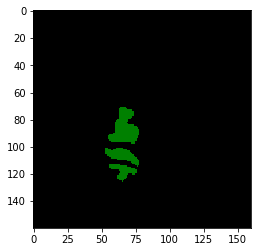

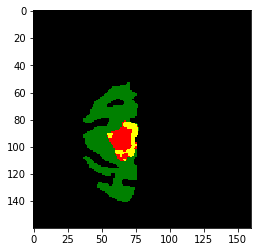

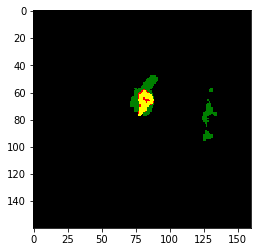

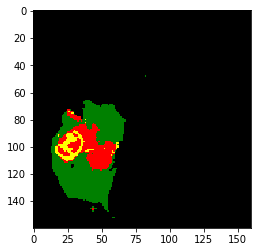

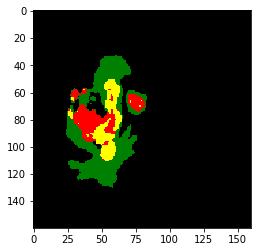

In [10]:
import matplotlib.pyplot as plt # plt 用于显示图片
import matplotlib.image as mpimg # mpimg 用于读取图片
import numpy as np

maskPath = glob("/Users/wushu/Desktop/MSc Project/Project/UNet2D/output/ShuWu_Unet_woDS/" + "GT/*.png")
pbPath = glob("/Users/wushu/Desktop/MSc Project/Project/UNet2D/output/ShuWu_Unet_woDS/" + "*.png")

for myi in tqdm(range(len(maskPath))):
    mask = imread(maskPath[myi])
    pb = imread(pbPath[myi])
    
for i in range(6,11):
    pb = mpimg.imread(pbPath[i])
    plt.imshow(pb)
    plt.show()

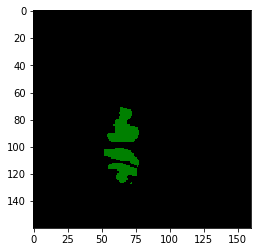

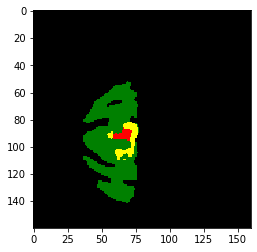

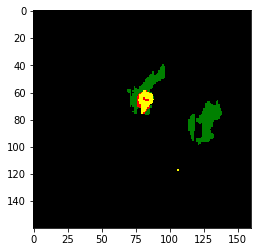

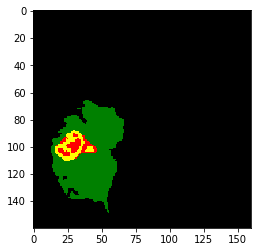

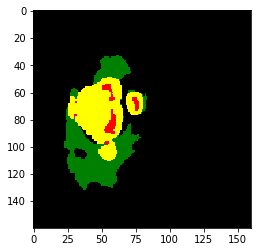

In [11]:
import matplotlib.pyplot as plt # plt 用于显示图片
import matplotlib.image as mpimg # mpimg 用于读取图片
import numpy as np

for i in range(6,11):
    mask = mpimg.imread(maskPath[i])
    plt.imshow(mask)
    plt.show()
    

In [24]:

mask = imread("/Users/wushu/Desktop/ceshi/10.png")
pb = imread("/Users/wushu/Desktop/ceshi/9.png")
dice = dice_coef(pb,mask)
iou = iou_score(pb,mask)
print(dice)
print(iou)

0.033580013790003
0.7347662314762549
